# Importing Libraries

In [72]:
from     alpha_vantage.foreignexchange import ForeignExchange
from     alpha_vantage.timeseries import TimeSeries
from     keras.layers import BatchNormalization, Conv1D, Dense, Dropout, Flatten, GRU, LSTM, MaxPooling1D, SimpleRNN
from     keras.models import Sequential
from     keras.optimizers import Adam
from     keras.callbacks import EarlyStopping
from     keras_tuner.tuners import RandomSearch
import   matplotlib.pyplot as plt
from     matplotlib.pyplot import figure
import   MetaTrader5 as mt5
import   numpy as np
import   pandas as pd
import   pandas_ta
import   plotly.graph_objs as go
import   plotly.offline as pox
from     sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from     sklearn.linear_model import LogisticRegression
from     sklearn.metrics import accuracy_score, classification_report, f1_score, mean_squared_error
from     sklearn.model_selection import train_test_split
from     sklearn.naive_bayes import GaussianNB
from     sklearn.neighbors import KNeighborsClassifier
from     sklearn.preprocessing import StandardScaler
from     sklearn.svm import SVC
from     sklearn.tree import DecisionTreeClassifier
import   seaborn as sns
from     statsmodels.tsa.stattools import adfuller
import   talib as ta
from     tensorflow.keras.callbacks import EarlyStopping
from     tensorflow.keras.optimizers import Adam
import   xgboost as XGBClassifier
import   yfinance as yf

In [73]:
import warnings
warnings.filterwarnings('ignore')

# Importing Stock Data

In [74]:
df = pd.read_csv(r'C:\Users\Daniel aghanya\Pictures\tiktok download\Final_Year_Project-main\Uni project\Project\aghanyan_Dissertation_Project_Files\Data\NSECleaned.csv')
# df.drop(df.tail(16).index,inplace=True)
next=df.copy()
next.tail()

,Date,Price,open,high,low,volume,Change %,close
1646,2023-12-18,72404.91,72389.23,72413.13,72276.75,324150000.0,0.0002,72404.91
1647,2023-12-19,72470.10,72404.91,72489.21,72320.32,411060000.0,0.0009,72470.10
1648,2023-12-20,73397.71,72470.10,73399.61,72470.10,552220000.0,0.0128,73397.71
1649,2023-12-21,74289.02,73397.71,74292.76,73397.71,760930000.0,0.0121,74289.02
1650,2023-12-22,74023.27,74288.88,74430.47,73993.49,423200000.0,-0.0036,74023.27


In [75]:
tfig = go.Figure()
tfig.add_trace(go.Candlestick(
    x=df.index, 
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='market data'
))

tfig.update_layout(
    title='NSE live share price evolution',
    yaxis_title='Stock Price (in $)'
)

tfig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label='15m', step='minute', stepmode='backward'),
            dict(count=45, label='45m', step='minute', stepmode='backward'),
            dict(count=1, label='HTD', step='hour', stepmode='todate'),
            dict(count=2, label='2h', step='hour', stepmode='backward'),
            dict(step='all')
        ])
    )
)

tfig.show()


# Feature Engineering

In [76]:
df['future_returns'] = df['close'].pct_change().shift(-1)
signal=[]
for i in range(len(df)):
            if (df['future_returns'][i]  > 0):
                signal.append(1)
            elif (df['future_returns'][i] < 0):
                signal.append(2)
            else:
                signal.append(3)

df['signal']=signal
df['rsi'] = ta.RSI(df['close'].values, timeperiod=int(14))
df['adx'] = ta.ADX(df['high'].values, df['low'].values,df['open'].values, timeperiod=int(50))
df['NATR'] = ta.NATR(df['high'], df['low'], df["close"], timeperiod=50)
df['pct_change5'] = df['close'].pct_change(5)
df['pct_change'] = df['close'].pct_change()
df['sma'] = ta.SMA(df['close'],timeperiod=30)
df['corr'] = df['close'].rolling(window=int(6.5*4)).corr(df['sma'])
df['Open-Close']=(df["open"]-df['close']).shift(-1)
df['Close-High']=(df["close"]-df['high']).shift(-1)
df['Close-Low']=(df["close"]-df['low']).shift(-1)
df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['upper_band'], df['middle_band'], df['lower_band'] = ta.BBANDS(df['close'], timeperiod=20)


## Calculate the log high/low and log close/open
#log_hl = np.log(df['high'] / df['low']) ** 2
#log_co = np.log(df['close'] / df['open']) ** 2
#
##Adding some Additional Feature engineeering techniques
## Rolling Windows
#df['rolling_mean'] = df['close'].rolling(window=20).mean()
#df['rolling_std'] = df['close'].rolling(window=20).std()
#df['ema50'] = df['close'].ewm(span=50, adjust=False).mean()
#
## Statistical Features
#df['rate_of_change'] = df['close'].pct_change().fillna(0)
#df['z_score'] = (df['close'] - df['rolling_mean']) / df['rolling_std']
#
## Feature Interaction
#df['close_volume_interaction'] = df['close'] * df['volume']


## Technical Indicators
#df['momentum'] = df['close'] - df['close'].shift(4)
#df['slowk'], df['slowd'] = ta.STOCH(df['high'], df['low'], df['close'], fastk_period=5, slowk_period=3, slowd_period=3)
df.dropna(inplace=True)
df

,Date,Price,open,high,low,volume,Change %,close,future_returns,signal,...,corr,Open-Close,Close-High,Close-Low,macd,macdsignal,macdhist,upper_band,middle_band,lower_band
99,2017-01-24,26217.54,26231.37,26296.54,26122.99,187700000.0,-0.0005,26217.54,0.000874,1,...,-0.744335,-22.91,-7.91,25.60,-16.968251,17.954208,-34.922459,26805.442738,26407.3615,26009.280262
100,2017-01-25,26240.45,26217.54,26248.36,26214.85,189990000.0,0.0009,26240.45,0.001886,1,...,-0.749888,-49.50,-5.34,78.70,-19.713139,10.420739,-30.133878,26797.823715,26395.0830,25992.342285
101,2017-01-26,26289.95,26240.45,26295.29,26211.25,146490000.0,0.0019,26289.95,0.001456,1,...,-0.732519,-38.27,-33.23,51.14,-17.690324,4.798526,-22.488850,26756.789365,26375.1680,25993.546635
102,2017-01-27,26328.22,26289.95,26361.45,26277.08,237790000.0,0.0015,26328.22,-0.004218,2,...,-0.710462,111.04,-122.17,26.05,-12.851020,1.268617,-14.119637,26685.229897,26352.4325,26019.635103
103,2017-01-30,26217.18,26328.22,26339.35,26191.13,143520000.0,-0.0042,26217.18,-0.006902,2,...,-0.716509,180.94,-208.56,124.02,-17.770984,-2.539303,-15.231681,26555.260574,26319.5605,26083.860426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,2023-12-15,72389.23,72458.76,72671.03,72368.30,307150000.0,-0.0009,72389.23,0.000217,1,...,0.854633,-15.68,-8.22,128.16,618.531836,610.967652,7.564184,72399.321538,71477.6645,70556.007462
1646,2023-12-18,72404.91,72389.23,72413.13,72276.75,324150000.0,0.0002,72404.91,0.000900,1,...,0.864426,-65.19,-19.11,149.78,620.098413,612.793804,7.304609,72526.218268,71547.4710,70568.723732
1647,2023-12-19,72470.10,72404.91,72489.21,72320.32,411060000.0,0.0009,72470.10,0.012800,1,...,0.860499,-927.61,-1.90,927.61,619.459481,614.126939,5.332542,72648.298073,71617.6485,70586.998927
1648,2023-12-20,73397.71,72470.10,73399.61,72470.10,552220000.0,0.0128,73397.71,0.012144,1,...,0.831631,-891.31,-3.74,891.31,685.896905,628.480933,57.415973,72987.672991,71737.3350,70486.997009


In [77]:
y = df[['signal']].copy()
print(y)
exclude_columns = ['Date', 'signal','NATR','adj close','close','future_returns','high','low','macdhist', 
                   'macdsignal','open','pct_change_5','pct_change','sma']   # Add any other columns you want to exclude from X
X = df[df.columns.difference(exclude_columns)]
print(X)

      signal
99         1
100        1
101        1
102        2
103        2
...      ...
1645       1
1646       1
1647       1
1648       1
1649       2

[1551 rows x 1 columns]
      Change %  Close-High  Close-Low  Open-Close     Price        adx  \
99     -0.0005       -7.91      25.60      -22.91  26217.54  25.121344   
100     0.0009       -5.34      78.70      -49.50  26240.45  24.888559   
101     0.0019      -33.23      51.14      -38.27  26289.95  24.642240   
102     0.0015     -122.17      26.05      111.04  26328.22  24.375187   
103    -0.0042     -208.56     124.02      180.94  26217.18  24.139882   
...        ...         ...        ...         ...       ...        ...   
1645   -0.0009       -8.22     128.16      -15.68  72389.23  31.166705   
1646    0.0002      -19.11     149.78      -65.19  72404.91  31.243861   
1647    0.0009       -1.90     927.61     -927.61  72470.10  31.327508   
1648    0.0128       -3.74     891.31     -891.31  73397.71  31.500122   
1649 

# Correlation Check

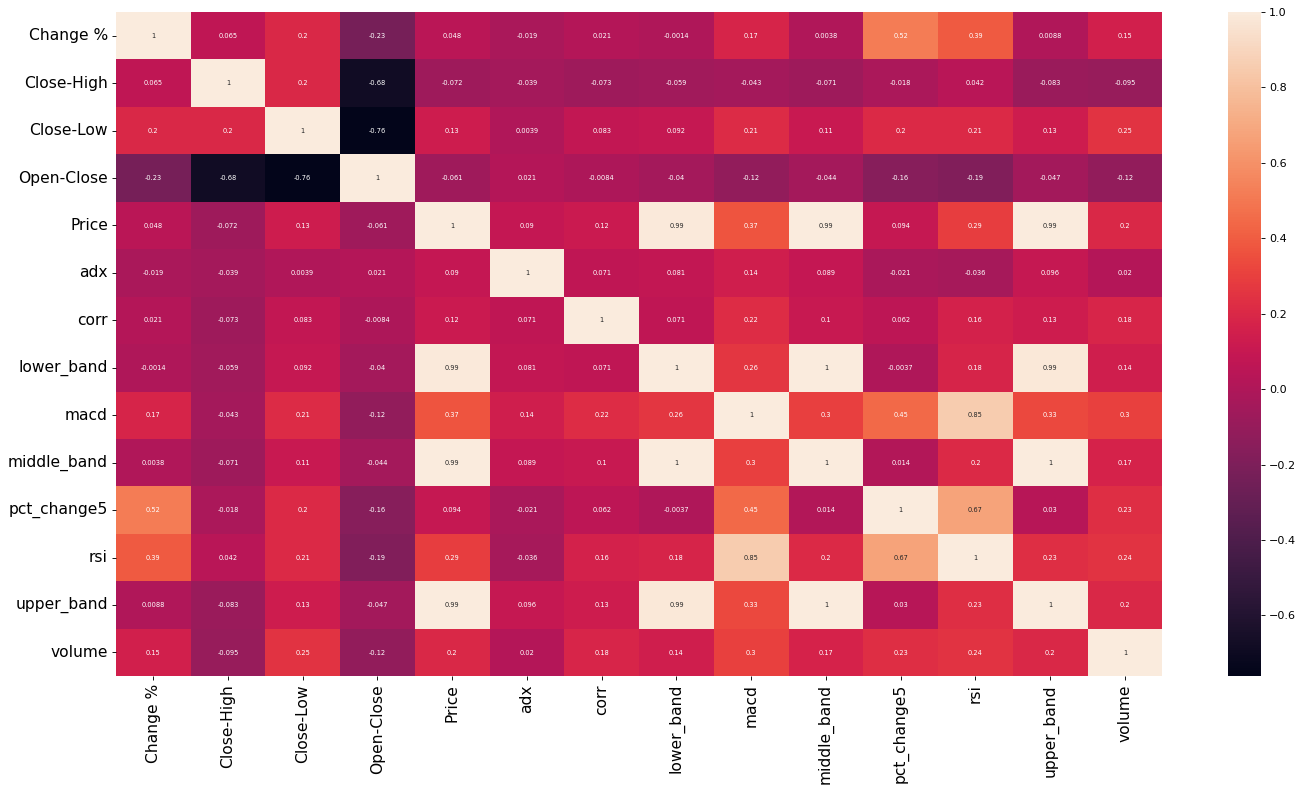

In [78]:
exclude_columns = ['Date', 'signal','NATR','adj close','close','future_returns','high','low','macdhist', 
                   'macdsignal','open','pct_change_5','pct_change','sma'] 
z=df[df.columns.difference(exclude_columns)].copy()
corr = z.corr()
figure(figsize=(18, 10), dpi=80)
sns.heatmap(corr, annot=True, annot_kws = {"size": 6})
plt.yticks(rotation=0, size = 14); 
plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

In [79]:
def get_pair_above_threshold(X, threshold):
    """Function to return the pairs with correlation above threshold.
    """
    # Calculate the correlation matrix
    correl = X.corr()

    # Unstack the matrix
    correl = correl.abs().unstack()

    # Recurring & redundant pair
    pairs_to_drop = set()
    cols = X.corr().columns
   
    for i in range(0, X.corr().shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))

    # Drop the recurring & redundant pair
    correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)

    return correl[correl > threshold].index


print(get_pair_above_threshold(X, 0.7))


MultiIndex([('middle_band',  'upper_band'),
            ( 'lower_band', 'middle_band'),
            (      'Price',  'upper_band'),
            (      'Price', 'middle_band'),
            (      'Price',  'lower_band'),
            ( 'lower_band',  'upper_band'),
            (       'macd',         'rsi'),
            (  'Close-Low',  'Open-Close')],
           )


# Stationary Check

In [80]:
def stationary(series):
    """Function to check if the series is stationary or not.
    """
    result = adfuller(series)
    if(result[1] < 0.05):
        return 'stationary'
    else:
        return 'not stationary'
# Check for stationarity
for col in X.columns:
    if stationary(df[col]) == 'not stationary':
        print('%s is not stationary. Dropping it.' % col)
        X.drop(columns=[col], axis=1, inplace=True)
    else:
        print('%s is stationary.' % col)
        


Change % is stationary.
Close-High is stationary.
Close-Low is stationary.
Open-Close is stationary.
Price is not stationary. Dropping it.
adx is stationary.
corr is stationary.
lower_band is not stationary. Dropping it.
macd is stationary.
middle_band is not stationary. Dropping it.
pct_change5 is stationary.
rsi is stationary.
upper_band is not stationary. Dropping it.
volume is stationary.


# Splitting and Training Model

In [81]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [82]:
def create_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [83]:
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [84]:
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [85]:
split_percentage = 0.8
split = int(split_percentage*len(df))


# Train data set
X_train = X[:split]
y_train = y[:split]
X_test =  X[split:]
y_test =  y[split:]
        
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

In [86]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1240, 10)
(1240, 1)
(311, 10)
(311, 1)


In [87]:
# Reshape input to be 3D [samples, timesteps, features]
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model = create_rnn_model(input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))

# Fit the model
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=2, shuffle=False)


Epoch 1/10
39/39 - 6s - loss: 2.1740 - val_loss: 0.9713 - 6s/epoch - 148ms/step
Epoch 2/10
39/39 - 0s - loss: 1.0440 - val_loss: 0.3797 - 157ms/epoch - 4ms/step
Epoch 3/10
39/39 - 0s - loss: 0.5088 - val_loss: 0.1820 - 145ms/epoch - 4ms/step
Epoch 4/10
39/39 - 0s - loss: 0.3261 - val_loss: 0.1620 - 149ms/epoch - 4ms/step
Epoch 5/10
39/39 - 0s - loss: 0.2802 - val_loss: 0.1547 - 162ms/epoch - 4ms/step
Epoch 6/10
39/39 - 0s - loss: 0.2818 - val_loss: 0.1508 - 409ms/epoch - 10ms/step
Epoch 7/10
39/39 - 0s - loss: 0.2678 - val_loss: 0.1425 - 415ms/epoch - 11ms/step
Epoch 8/10
39/39 - 0s - loss: 0.2610 - val_loss: 0.1452 - 219ms/epoch - 6ms/step
Epoch 9/10
39/39 - 0s - loss: 0.2395 - val_loss: 0.1400 - 160ms/epoch - 4ms/step
Epoch 10/10
39/39 - 0s - loss: 0.2362 - val_loss: 0.1424 - 157ms/epoch - 4ms/step


In [88]:
# Evaluate the model on the test set
y_pred = model.predict(X_test_reshaped)
y_pred = (y_pred > 0.5).astype(int)
Accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {Accuracy:.4f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score: {f1:.4f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

10/10 [==============================] - 1s 4ms/step
Accuracy: 0.6109
F1-Score: 0.4634
RMSE: 0.6238


In [89]:
# Correct reshaping
X_train_reshaped1 = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped1 = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


model = create_cnn_model(input_shape=(X_train_reshaped1.shape[1], 1))

# Fit the model
history1 = model.fit(X_train_reshaped1, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped1, y_test), verbose=2, shuffle=False)

Epoch 1/10
39/39 - 2s - loss: -1.7524e+00 - accuracy: 0.4911 - val_loss: -3.6479e+00 - val_accuracy: 0.6109 - 2s/epoch - 46ms/step
Epoch 2/10
39/39 - 0s - loss: -1.1471e+01 - accuracy: 0.4984 - val_loss: -1.6656e+01 - val_accuracy: 0.6109 - 184ms/epoch - 5ms/step
Epoch 3/10
39/39 - 0s - loss: -4.1430e+01 - accuracy: 0.4984 - val_loss: -5.1390e+01 - val_accuracy: 0.6109 - 183ms/epoch - 5ms/step
Epoch 4/10
39/39 - 0s - loss: -1.1097e+02 - accuracy: 0.4984 - val_loss: -1.2297e+02 - val_accuracy: 0.6109 - 172ms/epoch - 4ms/step
Epoch 5/10
39/39 - 0s - loss: -2.4117e+02 - accuracy: 0.4984 - val_loss: -2.4708e+02 - val_accuracy: 0.6109 - 229ms/epoch - 6ms/step
Epoch 6/10
39/39 - 0s - loss: -4.5319e+02 - accuracy: 0.4984 - val_loss: -4.3924e+02 - val_accuracy: 0.6109 - 309ms/epoch - 8ms/step
Epoch 7/10
39/39 - 0s - loss: -7.7075e+02 - accuracy: 0.4984 - val_loss: -7.1519e+02 - val_accuracy: 0.6109 - 369ms/epoch - 9ms/step
Epoch 8/10
39/39 - 0s - loss: -1.2196e+03 - accuracy: 0.4984 - val_loss

In [90]:
# Evaluate the model on the test set
y_pred1 = model.predict(X_test_reshaped1)
y_pred1 = (y_pred1 > 0.5).astype(int)
Accuracy = accuracy_score(y_test, y_pred1)
print(f"Accuracy: {Accuracy:.4f}")

f1 = f1_score(y_test, y_pred1, average='weighted')
print(f"F1-Score: {f1:.4f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred1))
print(f"RMSE: {rmse:.4f}")

10/10 [==============================] - 0s 2ms/step
Accuracy: 0.6109
F1-Score: 0.4634
RMSE: 0.6238


# confusion Matrix

In [91]:
# Classification report
classification_report_data = classification_report(y_test, y_pred)
# Print the classification report
print(classification_report_data)

              precision    recall  f1-score   support

           1       0.61      1.00      0.76       190
           2       0.00      0.00      0.00       121

    accuracy                           0.61       311
   macro avg       0.31      0.50      0.38       311
weighted avg       0.37      0.61      0.46       311



# Making Latest Prediciton

In [92]:
split_percentage = 0.8
split = int(split_percentage*len(df))
temp=pd.DataFrame()
temp['close'] = df.close.iloc[split:]
temp['signal']=np.array(y_pred)
temp.tail()

,close,signal
1645,72389.23,1
1646,72404.91,1
1647,72470.10,1
1648,73397.71,1
1649,74289.02,1


In [93]:
# Variable Required for decision making
buy=[]
sell=[]
profit=[]
Close_profit=[]
Stop_loss=[]
Close_order_buy=[]
Close_order_sell=[]
position_Buy=None
position_Sell=None
profit=0.4
lose=0.4

# Decision Making Process

In [94]:
for i in range(len(temp)):
   #####################################################################################################
    if position_Buy!="Buy"  and position_Sell!="Sell" and Accuracy >0.50 and temp['signal'].iloc[i]== 1 :                          #Buy Position
                    buy.append(temp['close'].iloc[i])
                    sell.append(np.nan)
                    Close_profit.append(np.nan)
                    Stop_loss.append(np.nan)
                    Close_order_buy.append(temp['close'].iloc[i])
                    position_Buy="Buy"
    #############################################################################################
    elif  position_Sell!="Sell"  and position_Buy!="Buy" and Accuracy >0.50 and temp['signal'].iloc[i]== 2   :                     #Sell Position        
                sell.append(temp['close'].iloc[i])              
                buy.append(np.nan)
                Close_profit.append(np.nan)
                Stop_loss.append(np.nan)
                Close_order_sell.append(temp['close'].iloc[i])
                position_Sell="Sell"
        
    #################################################################################################
    elif position_Sell=="Sell" :                                               #Closing Order  After  Buying a trade(Profit)
        if ((Close_order_sell[-1]+lose) <= temp['close'].iloc[i]):                   #Take Profit Condition
            Close_profit.append(np.nan)                                        #append to take profit
            Stop_loss.append(temp['close'].iloc[i])
            buy.append(np.nan)
            sell.append(np.nan)
            position_Sell=None
        elif ((Close_order_sell[-1]-(profit)) >= temp['close'].iloc[i]):                   #Stop Loss Condition
            Close_profit.append(temp['close'].iloc[i])
            Stop_loss.append(np.nan)                                                #Appending to stop loss
            buy.append(np.nan)
            sell.append(np.nan)
            position_Sell=None
        else:
            Close_profit.append(np.nan)
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
    ########################################################################################################
    elif position_Buy=="Buy" :                                               #Closing Order  After  Buying a trade(Profit)
        if ((Close_order_buy[-1]+profit) <= temp['close'].iloc[i]):                  #Take Profit Condition
            Close_profit.append(temp['close'].iloc[i])                          #append to take profit
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
            position_Buy=None
           
        elif ((Close_order_buy[-1]-lose) >= temp['close'].iloc[i]):                   #Stop Loss Condition
            Close_profit.append(np.nan)
            Stop_loss.append(temp['close'].iloc[i])                                  #Appending to stop loss
            buy.append(np.nan)
            sell.append(np.nan)
            df['future_returns'] = df['close'].pct_change().shift(-1)
            position_Buy=None
     
        else:
            Close_profit.append(np.nan)
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
#################################################################
    else:
            buy.append(np.nan)
            sell.append(np.nan)
            Stop_loss.append(np.nan)
            Close_profit.append(np.nan)
temp['buy']=buy
temp['sell']=sell
temp['Close_profit']=Close_profit
temp['Stop_loss']=Stop_loss
print((temp[temp['buy']!=np.nan]).count())
print(f"Profitibily { temp['Close_profit'].count()/(temp['Close_profit'].count()+temp['Stop_loss'].count())}")

close           311
signal          311
buy             155
sell              0
Close_profit     94
Stop_loss        61
dtype: int64
Profitibily 0.6064516129032258


# Plotting

In [95]:

trace1=go.Scatter(
    y=temp.close,
    mode='lines',
    name='Close_price'
)

trace4=go.Scatter(
   
    y=temp['buy'],
    mode='markers',
    marker=dict(size=13,color='#00FF00',symbol='triangle-up' ),
    name='buy'
    )
trace5=go.Scatter(
    
    y=temp.sell,
    mode='markers',
    marker=dict(size=13,color='#FF0000',symbol='triangle-down'),
    name='sell')
trace6=go.Scatter(
    
    y=temp.Close_profit,
    mode='markers',
    marker=dict(size=13,color='#00FF00',symbol='cross'),
    name='Profit')
trace7=go.Scatter(
    
    y=temp.Stop_loss,
    mode='markers',
    marker=dict(size=13,color='#FF0000',symbol='cross'),
    name='Loss')

data=[trace1,trace4,trace5,trace6,trace7]
layout=go.Layout(
    title="NSE_ANN",
    yaxis=dict(title='Assest value'),
    xaxis=dict(title='Time And date'))


figure=go.Figure(data=data,layout=layout)
figure.update_layout(xaxis_rangeslider_visible=False)
pox.plot(figure)

'temp-plot.html'